In [ ]:
# dataset (data.csv) link: https://huggingface.co/datasets/AmirMohseni/GroceryList/viewer/default/train?utm_source=chatgpt.com
# final_grocery_dataset.csv contains all data

In [74]:
import numpy as np
import tensorflow as tf
import keras as keras
import pandas as pd
import json
from keras import layers
from sklearn.model_selection import train_test_split
# print(keras.__version__)
# keras.backend.backend()


In [75]:
# basic cleaning 
def clean_text(s: str) -> str:
    s = str(s).lower().strip()
    s = " ".join(s.split())
    return s

# load dataset
final_df = pd.read_csv("data/final_grocery_dataset.csv", names=["Item", "Category"])

# clean text
final_df["Item"] = final_df["Item"].apply(clean_text)
final_df["Category"] = final_df["Category"].str.strip()

# remove dupes
final_df = final_df.drop_duplicates(subset=["Item", "Category"]).reset_index(drop=True)

# print(df["Category"].value_counts())
# print("Total rows:", len(df))

print(len(final_df))




1385


In [76]:
CAP = 130

limited_dfs = []

for category in final_df["Category"].unique():
    limited_dfs.append(
        final_df[final_df["Category"] == category].head(CAP)
    )

final_df = pd.concat(limited_dfs, ignore_index=True)

print(final_df["Category"].value_counts())

Category
Other                  130
Snacks                 130
Bakery                 130
Pet Supplies           130
Dairy & Eggs           108
Beverages               93
Condiments & Sauces     89
Produce                 62
Meat & Seafood          43
Frozen Foods            36
Household               35
Canned Goods            32
Pasta & Grains          21
Pantry                  18
Personal Care           16
Deli                    13
Category                 1
Name: count, dtype: int64


In [113]:
# merge smaller categories 

category_merge_map = {
    "Condiments & Sauces": "Pantry Items",
    "Canned Goods": "Pantry Items",
    "Pantry": "Pantry Items",

    "Pasta & Grains": "Grains & Bakery",
    "Bakery": "Grains & Bakery",

    "Deli": "Meat & Deli",
    "Meat & Seafood": "Meat & Deli",
}

final_df["Category"] = final_df["Category"].replace(category_merge_map)

In [114]:
# encode labels - used chat gpt to help write this cell

# df = final_df.copy()

final_df = final_df[final_df["Category"] != "Category"].reset_index(drop=True)

# encode labels
categories = sorted(final_df["Category"].unique().tolist())

cat_to_idx = {}
for idx, category in enumerate(categories):
    cat_to_idx[category] = idx

idx_to_cat = {}
for category, idx in cat_to_idx.items():
    idx_to_cat[idx] = category

final_df["label"] = final_df["Category"].map(cat_to_idx)

print("Number of categories:", len(categories))
print(cat_to_idx)


Number of categories: 12
{'Beverages': 0, 'Dairy & Eggs': 1, 'Frozen Foods': 2, 'Grains & Bakery': 3, 'Household': 4, 'Meat & Deli': 5, 'Other': 6, 'Pantry Items': 7, 'Personal Care': 8, 'Pet Supplies': 9, 'Produce': 10, 'Snacks': 11}


In [115]:
# train/text split

X_train, X_test, y_train, y_test = train_test_split(
    final_df["Item"].values,
    final_df["label"].values,
    test_size=0.2,
    random_state=42,
    stratify=final_df["label"].values
)

In [116]:
# text vectoriser
max_tokens = 5000
sequence_length = 20
vectorizer = layers.TextVectorization(
    max_tokens=5000,
    ngrams = 2,
    output_mode="int",
    output_sequence_length=sequence_length
)
vectorizer.adapt(X_train)

In [117]:
# define model 

num_classes = len(categories)

inputs = keras.Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = layers.Embedding(input_dim=max_tokens, output_dim=64)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_12           │ (None, 20)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 20, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_13     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,940 (1.24 MB)

 Trainable params: 324,940 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
# train
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1297 - loss: 2.4531 - val_accuracy: 0.1609 - val_loss: 2.4303
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1571 - loss: 2.3844 - val_accuracy: 0.1494 - val_loss: 2.3884
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1772 - loss: 2.3368 - val_accuracy: 0.1494 - val_loss: 2.3526
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2406 - loss: 2.2739 - val_accuracy: 0.1667 - val_loss: 2.3094
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2680 - loss: 2.2159 - val_accuracy: 0.2299 - val_loss: 2.2300
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2968 - loss: 2.1346 - val_accuracy: 0.3218 - val_loss: 2.1392
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3357 - loss: 2.0486 - val_accuracy: 0.2931 - val_loss: 2.0689
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3631 - loss: 1.9919 - val_accuracy: 0.3678 - val_loss:

In [119]:
# evaluate 
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5505 - loss: 1.4731
Test accuracy: 0.5504587292671204


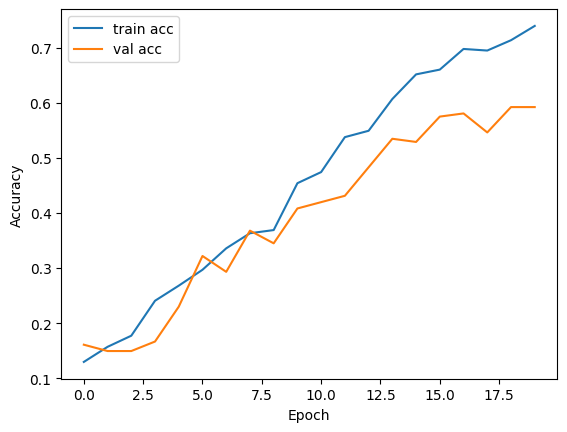

In [ ]:
# check for overfitting - use chatgpt to help write and understand this correctly
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# this is in the interface file (only here for testing) 

# def predict_category(item_name: str, threshold=0.5):
#     item_name = clean_text(item_name)

#     x = tf.constant([[item_name]])
#     probs = model.predict(x, verbose=0)[0]

#     max_prob = float(probs.max())
#     pred_idx = int(probs.argmax())

#     if max_prob < threshold:
#         return "Other", max_prob

#     return idx_to_cat[pred_idx], max_prob


# print(predict_category("oat milk"))
# print(predict_category("chocolate biscuits"))
# print(predict_category("sourdough bread"))
# print(predict_category("toothpaste"))
# print(predict_category("oil"))
# print(predict_category("chicken"))
# print(predict_category("dry cat food")) 


('Other', 0.38576292991638184)
('Other', 0.21808284521102905)
('Grains & Bakery', 0.7206591367721558)
('Other', 0.17957228422164917)
('Other', 0.23095408082008362)
('Other', 0.18567687273025513)
('Pet Supplies', 0.7762845158576965)


In [122]:
# save model
model.save("model.keras")

# save label map
with open("label_map.json", "w") as f:
    json.dump({int(k): v for k, v in idx_to_cat.items()}, f)